In [3]:
from dotenv import load_dotenv

load_dotenv()

from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain.chat_models import init_chat_model
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver

In [10]:
class State(TypedDict):
    #Preserves og message
    #add_messages update the messages list as a way to 
    #preserve message history
    messages: Annotated[list,add_messages]

memory = MemorySaver()
    

In [11]:
@tool
#Access latest stock price
def get_stock_price(symbol:str)->float:
    '''Return the current price of a stock given the stock symbol
    :param symbol - the stock symbol
    :return - current price of that stock'''

    return{
        "MSFT":200.3,
        "AAPL":100.4,
        "AMZN":150,
        "RIL":87.6
    }.get(symbol,0.0)

tools = [get_stock_price]

llm_2 = init_chat_model("google_genai:gemini-2.0-flash")

llm_with_tools = llm_2.bind_tools(tools)

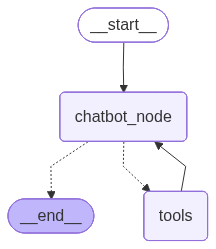

In [12]:
def chatbot(state:State)->State:
    return {"messages":[llm_with_tools.invoke(state["messages"])]}


builder2 = StateGraph(State)
builder2.add_node("chatbot_node",chatbot)
builder2.add_node("tools",ToolNode(tools))
builder2.add_edge(START,"chatbot_node")
builder2.add_conditional_edges("chatbot_node",tools_condition)
builder2.add_edge("tools","chatbot_node")
builder2.add_edge("chatbot_node",END)

graph2 = builder2.compile(checkpointer=memory)

display(Image(graph2.get_graph().draw_mermaid_png()))

In [14]:
config = { 'configurable' :{ 'thread_id' : '1'}}
state = graph2.invoke({"messages": [{"role":"user","content":"What is the price of the AMZN stock?"}]}, config=config)
print(state["messages"][-1].content)


The current price of AMZN stock is $150.


In [15]:
#Multiple iterations based on its own responses for reasoning purposes
#config creates a thread for the model to look back at for memory


config = { 'configurable' :{ 'thread_id' : '1'}}

msg = "I want to buy 20 AMZN stocks and then 15 MSFT after (using the current price). what will be the total cost?"

state = graph2.invoke({"messages":[{"role":"user","content":msg}]},config=config)
print(state["messages"][-1].content)

The current price of AMZN is $150 and MSFT is $200.3.

The cost of 20 AMZN stocks is 20 * $150 = $3000.
The cost of 15 MSFT stocks is 15 * $200.3 = $3004.5.

The total cost would be $3000 + $3004.5 = $6004.5.


In [16]:
#Multiple iterations based on its own responses for reasoning purposes
#config creates a thread for the model to look back at for memory

#Test memory capabilites of the llm

config = { 'configurable' :{ 'thread_id' : '1'}}

msg = "Using the current price, tell me the total price of 10 RIL stocks and add it to the previous total?"

state = graph2.invoke({"messages":[{"role":"user","content":msg}]},config=config)
print(state["messages"][-1].content)

OK. The current price of RIL is $87.6. The cost of 10 RIL stocks is 10 * $87.6 = $876.

The previous total was $6004.5. Adding the cost of the RIL stocks, the new total is $6004.5 + $876 = $6880.5.
